<h1 align=center><font size = 5>Pre-Trained ResNet50 & VGG16 Models</font></h1>

## Objective


In this lab, we will build pretrained ResNet50 classifier model which later will be used to compare performance to VGG16 model

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3> 
    
1. <a href="#item31">Import Libraries and Packages</a>
2. <a href="#item32">Download Data</a>  
3. <a href="#item33">Define Global Constants</a>  
4. <a href="#item34">Construct ImageDataGenerator Instances</a>  
5. <a href="#item35">Compile and Fit Model</a>

</font>
    
</div>


<a id='item31'></a>


## Import Libraries and Packages


Let's start the lab by importing the libraries that we will be using in this lab. First we will need the library that helps us to import the data.


In [1]:
import os 

First, we will import the ImageDataGenerator module since we will be leveraging it to train our model in batches.


In [2]:
from keras.preprocessing.image import ImageDataGenerator

In this lab, we will be using the Keras library to build an image classifier, so let's download the Keras library.


In [3]:
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense

Finally, we will be leveraging the ResNet50 model to build our classifier, so let's download it as well.


In [4]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

<a id='item32'></a>


## Download Data


Dataset link: https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/concrete_data_week3.zip

In [46]:
# # unzip files
import zipfile
with zipfile.ZipFile('PYTHON_CODE/data/concrete_data_week3.zip', 'r') as zip_ref:
    zip_ref.extractall('PYTHON_CODE/data')

After you unzip the data, you fill find the data has already been divided into a train & validation sets.

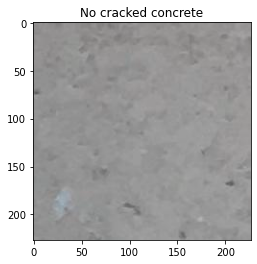

In [2]:
import cv2
import matplotlib.pyplot as plt
img = cv2.imread('data/concrete_data_week3/train/negative/00018.jpg')
plt.title('No cracked concrete')
plt.imshow(img)

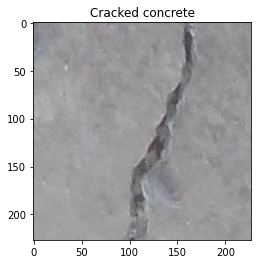

In [3]:
img = cv2.imread('data/concrete_data_week3/train/positive/00010.jpg')
plt.title('Cracked concrete')
plt.imshow(img)

In [13]:
path = 'data/concrete_data_week3'
os.listdir(path)

['.DS_Store', 'train', 'valid']

In [15]:
path = 'data/concrete_data_week3/train/positive'
len(os.listdir(path))

15001

There are tens of thousand of jpg file, therefore I recommend as I always do when it comes to big data, use **zipfile** to unzip and extract downloaded files & **os** lib to move, rename, check extracted files.

<a id='item33'></a>


## Define Global Constants


Here, we will define constants that we will be using throughout the rest of the lab. 

1. We are obviously dealing with two classes, so *num_classes* is 2. 
2. The ResNet50 model was built and trained using images of size (224 x 224). Therefore, we will have to resize our images from (227 x 227) to (224 x 224).
3. We will training and validating the model using batches of 100 images.


In [16]:
num_classes = 2

image_resize = 224

batch_size_training = 100
batch_size_validation = 100

<a id='item34'></a>


## Construct ImageDataGenerator Instances


In order to instantiate an ImageDataGenerator instance, we will set the **preprocessing_function** argument to *preprocess_input* which we imported from **keras.applications.resnet50** in order to preprocess our images the same way the images used to train ResNet50 model were processed.


In [17]:
data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

Next, we will use the *flow_from_directory* method to get the training images as follows:


In [18]:
train_generator = data_generator.flow_from_directory(
    'data/concrete_data_week3/train',
    target_size=(image_resize, image_resize),
    batch_size=batch_size_training,
    class_mode='categorical')

Found 30001 images belonging to 2 classes.


**Note**: in this lab, we will be using the full data-set of 40,000 images for training and validation.


**Your Turn**: Use the *flow_from_directory* method to get the validation images and assign the result to **validation_generator**.


In [19]:
validation_generator = data_generator.flow_from_directory(
    'data/concrete_data_week3/valid',
    target_size=(image_resize, image_resize),
    batch_size=batch_size_validation,
    class_mode='categorical')

Found 10001 images belonging to 2 classes.


<a id='item35'></a>


## Build, Compile and Fit Model


In this section, we will start building our model. We will use the Sequential model class from Keras.


In [20]:
model = Sequential()

Next, we will add the ResNet50 pre-trained model to out model. However, note that we don't want to include the top layer or the output layer of the pre-trained model. We actually want to define our own output layer and train it so that it is optimized for our image dataset. In order to leave out the output layer of the pre-trained model, we will use the argument *include_top* and set it to **False**.


In [21]:
model.add(ResNet50(
    include_top=False,
    pooling='avg',
    weights='imagenet',
    ))

94781440/94765736 [==============================] - 6s 0us/step


Then, we will define our output layer as a **Dense** layer, that consists of two nodes and uses the **Softmax** function as the activation function.


In [22]:
model.add(Dense(num_classes, activation='softmax'))

You can access the model's layers using the *layers* attribute of our model object. 


In [23]:
model.layers

You can see that our model is composed of two sets of layers. The first set is the layers pertaining to ResNet50 and the second set is a single layer, which is our Dense layer that we defined above.


You can access the ResNet50 layers by running the following:


In [24]:
model.layers[0].layers

Since the ResNet50 model has already been trained, then we want to tell our model not to bother with training the ResNet part, but to train only our dense output layer. To do that, we run the following.


In [25]:
model.layers[0].trainable = False

And now using the *summary* attribute of the model, we can see how many parameters we will need to optimize in order to train the output layer.


In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


Next we compile our model using the **adam** optimizer.


In [27]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Before we are able to start the training process, with an ImageDataGenerator, we will need to define how many steps compose an epoch. Typically, that is the number of images divided by the batch size. Therefore, we define our steps per epoch as follows:


In [28]:
steps_per_epoch_training = len(train_generator)
steps_per_epoch_validation = len(validation_generator)
num_epochs = 2

Finally, we are ready to start training our model. Unlike a conventional deep learning training were data is not streamed from a directory, with an ImageDataGenerator where data is augmented in batches, we use the **fit_generator** method.


In [29]:
fit_history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch_training,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=steps_per_epoch_validation,
    verbose=1,
)

C:\Users\QUANGH~1\AppData\Local\Temp/ipykernel_11684/251737888.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  fit_history = model.fit_generator(


Epoch 1/2
301/301 [==============================] - 5485s 18s/step - loss: 0.0254 - accuracy: 0.9913 - val_loss: 0.0057 - val_accuracy: 0.9987
Epoch 2/2
301/301 [==============================] - 5704s 19s/step - loss: 0.0049 - accuracy: 0.9988 - val_loss: 0.0043 - val_accuracy: 0.9991


Now that the model is trained, you are ready to start using it to classify images.


Since training can take a long time when building deep learning models, it is always a good idea to save your model once the training is complete if you believe you will be using the model again later. You will be using this model in the next module, so go ahead and save your model.


In [30]:
model.save('keras_classifier_resnet_model.h5')

Now, you should see the model file **keras_classifier_resnet_model.h5** apprear in the working directory pane. After train and save model, we are gonna import pretrained VGG16 and repeat training step for later model comparison

## Build, Compile and Fit VGG16 Model 

This part is not different from ResNet50 so we will speed up through whole process

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications.vgg16 import preprocess_input

# 1.2. Use a batch size of 100 images for both training and validation.
batch_size = 100

# 1.3. Construct an ImageDataGenerator for the training set and another one for the validation set. 
data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)
train_generator = data_generator.flow_from_directory(
    'D:/PYTHON_CODE/data/concrete_data_week4/train',
    target_size=(image_resize, image_resize),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
    'D:/PYTHON_CODE/data/concrete_data_week3/valid',
    target_size=(image_resize, image_resize),
    batch_size=batch_size,
    class_mode='categorical')

# 1.4. Create a sequential model using Keras. Add VGG16 model to it and dense layer.
model = Sequential()

# Next, we will add the VGG16 pre-trained model to out model. However, note that we don't want to include the top layer or the output layer of the pre-trained model. We actually want to define our own output layer and train it so that it is optimized for our image dataset. In order to leave out the output layer of the pre-trained model, we will use the argument include_top and set it to False.
model.add(keras.applications.vgg16.VGG16(include_top=False, weights="imagenet", pooling="avg"))

# Then, we will define our output layer as a Dense layer, that consists of two nodes and uses the Softmax function as the activation function.
model.add(Dense(num_classes, activation='softmax'))

# Since the VGG16 model has already been trained, then we want to tell our model not to bother with training the ResNet part, but to train only our dense output layer. To do that, we run the following.
model.layers[0].trainable = False

# 1.5. Compile the mode using the adam optimizer and the categorical_crossentropy loss function.
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 1.6. Fit the model on the augmented data using the ImageDataGenerators.
steps_per_epoch_training = len(train_generator)
steps_per_epoch_validation = len(validation_generator)
num_epochs = 2

fit_history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch_training,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=steps_per_epoch_validation,
    verbose=1,
)

model.save('keras_classifier_vgg16_model.h5')

Since VGG16 model took too much fitting times and had the tendency to crash ipykernel while running. The model (or any other models) will be run as Python script on .py file rather than .ipynb. The code above is simply for demostration.

## Conclusion

So we have trained & evaluated both ResNet50 & VGG16 pretrained models. In the next notebook, we will load & compare those two models with the same test dataset.

### Thank you for going through this notebook with me